In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('titanic (2).csv')

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
df.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [31]:
features_dr=['Name','Cabin']
df=df.drop(features_dr,axis=1)

In [32]:
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Fare'] = df['Fare'].fillna(df['Fare'].median())

In [19]:
df['Sex_binary'] = df['Sex'].map({'male': 0, 'female': 1})

In [20]:
features = ['Pclass', 'Sex_binary', 'Age', 'SibSp', 'Parch', 'Fare']
X = df[features].values
y = df['Survived'].values

In [21]:
X_std = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

In [23]:
def manual_pca(X, n_components=3):
    cov_matrix = np.cov(X.T)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    idx = eigenvalues.argsort()[::-1]
    components = eigenvectors[:, idx[:n_components]]
    return np.dot(X, components)

In [24]:
X_pca = manual_pca(X_std, n_components=3)
#pca complete

In [25]:
y_svm = np.where(y == 0, -1, 1)

In [82]:
def train_svm(X, y, lr=0.001, lambda_param=0.01, epochs=1000):
    weights = np.zeros(X.shape[1])
    bias = 0
    for _ in range(epochs):
        for idx, x_i in enumerate(X):
            # Hinge Loss Condition
            condition = y[idx] * (np.dot(x_i, weights) - bias) >= 1
            if condition:
                weights -= lr * (2 * lambda_param * weights)
            else:
                weights -= lr * (2 * lambda_param * weights - np.dot(x_i, y[idx]))
                bias -= lr * y[idx]
    return weights, bias

In [37]:
indices = np.random.permutation(len(X_pca))
train_idx, test_idx = indices[:int(len(X)*0.8)], indices[int(len(X)*0.8):]
X_train, X_test = X_pca[train_idx], X_pca[test_idx]
y_train, y_test = y_svm[train_idx], y_svm[test_idx]

In [38]:
w, b = train_svm(X_train, y_train)

In [39]:
y_pred = np.sign(np.dot(X_test, w) - b)
accuracy = np.mean(y_pred == y_test)

In [80]:
print(f"SVM Accuracy with 3 PCA Components: {accuracy * 100:.2f}%")
print("\nConfusion Matrix:")
print(f"                     Predicted 0    Predicted 1")
print(f"Actual 0 (Died)      {cm[0,0]:<14} {cm[0,1]}")
print(f"Actual 1 (Survived)  {cm[1,0]:<14} {cm[1,1]}")

SVM Accuracy with 3 PCA Components: 83.24%

Confusion Matrix:
                     Predicted 0    Predicted 1
Actual 0 (Died)      94             12
Actual 1 (Survived)  17             56


In [56]:
#Applying Logistic Regression
X_log = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
X_log = np.c_[np.ones(X.shape[0]), X]

/tmp/ipython-input-2470164213.py:2: RuntimeWarning: invalid value encountered in divide
  X_log = (X - np.mean(X, axis=0)) / np.std(X, axis=0)


In [57]:
indices = np.random.permutation(len(X))
split_idx = int(len(X) * 0.8)
train_idx, test_idx = indices[:split_idx], indices[split_idx:]

In [58]:
X_train, X_test = X_log[train_idx], X_log[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [75]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z.astype(float)))
def compute_cost(y, h):
    return -np.mean(y * np.log(h) + (1 - y) * np.log(1 - h))
def train_model(X, y, lr=0.1, epochs=1000):
    weights = np.zeros(X.shape[1])
    cost_history = []
    for _ in range(epochs):
        z = np.dot(X, weights)
        h = sigmoid(z)
        gradient = np.dot(X.T, (h - y)) / y.size
        weights -= lr * gradient
        cost_history.append(compute_cost(y, h))
    return weights, cost_history
def predict(X, weights):
    return (sigmoid(np.dot(X, weights)) >= 0.5).astype(int)


Text(0, 0.5, 'Cost')

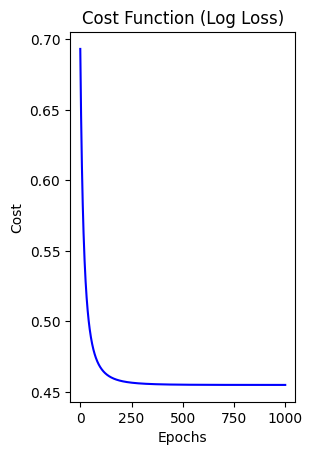

In [76]:
plt.subplot(1, 2, 1)
plt.plot(cost_history, color='blue')
plt.title('Cost Function (Log Loss)')
plt.xlabel('Epochs')
plt.ylabel('Cost')

In [89]:
weights, cost_history = train_model(X_train, y_train)

In [90]:
y_pred_probs = sigmoid(np.dot(X_test, weights))
y_predlog = (y_pred_probs >= 0.5).astype(int)